In [1]:
import pandas as pd

%store -r t

data = pd.read_csv('./fakeData/labelledDataSOM' + t +'.csv')

X = data[['sex', 'valueLog',
       'marketing', 'moveFreq', 'moveDur', 'premsFreq', 'premsMean',
       'premsMax', 'premsMin', 'premsMedian', 'premsDur', 'traceability']].to_numpy()

labels = data['cluster'].to_list()

columnnames = ['sex', 'valueLog',
       'marketing', 'moveFreq', 'moveDur', 'premsFreq', 'premsMean',
       'premsMax', 'premsMin', 'premsMedian', 'premsDur', 'traceability']

datacl = data[['perno','cluster']]

prems = pd.read_csv('./fakeData/prems' + t + '.csv')

premslabelled = pd.merge(prems,datacl, on = 'perno')

In [2]:
import numpy as np
import colorsys
import matplotlib.pyplot as plt
from datetime import datetime
from time import mktime

def getPlotValues(date,dates, amountclus, reduce = 'month'): #returns stats for every day
    if reduce == 'day':
        x = datetime.strptime(date, '%Y-%m-%d')
        vals = amountclus[[i for i, d in enumerate(dates) if d == date]]
    elif reduce == 'month':
        x = datetime.strptime(date, '%Y-%m')
        vals = amountclus[[i for i, d in enumerate(dates) if d[:-3] == date]]
    else:
        x = datetime.strptime(date, '%Y')
        vals = amountclus[[i for i, d in enumerate(dates) if d[:-6] == date]]

    y = np.mean(vals)
    ymax = max(vals)
    ymin = min(vals)
    return x,y ,ymax ,ymin

N = max(premslabelled['cluster'])+1
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples =list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))


def createTimeSeriesGraph(dates, amounts, labels, reduce='month', smooth = True, title=None):
    
    N = max(labels)+1
    HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
    RGB_tuples =list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    
    fig, ax = plt.subplots(figsize=(25, 6))
    
    ys=[]
    for cluster in np.unique(labels):
        if reduce == 'year':
            amountclus = amounts[[i for i, lab in enumerate(labels) if lab == cluster]]
            datesclus = dates[[i for i, lab in enumerate(labels) if lab == cluster]]
            uniquedates = np.unique([s[:-6] for s in datesclus])
            vals = np.array([getPlotValues(date,datesclus,amountclus, reduce) for date in uniquedates])

        elif reduce == 'month':
            amountclus = amounts[[i for i, lab in enumerate(labels) if lab == cluster]]
            datesclus = dates[[i for i, lab in enumerate(labels) if lab == cluster]]
            uniquedates = np.unique([s[:-3] for s in datesclus])
            vals = np.array([getPlotValues(date,datesclus,amountclus, reduce) for date in uniquedates])
            
        else:
            amountclus = amounts[[i for i, lab in enumerate(labels) if lab == cluster]]
            datesclus = dates[[i for i, lab in enumerate(labels) if lab == cluster]]
            uniquedates = np.unique([s for s in datesclus])
            vals = np.array([getPlotValues(date,datesclus, amountclus, reduce) for date in uniquedates])
            
        x = vals[:,0]
        y = vals[:,1].astype('float64')
        ymax = vals[:,2].astype('float64')
        ymin = vals[:,3].astype('float64')

        xnew = [mktime(i.timetuple()) for i in x]
        xnewticks = np.linspace(min(xnew),max(xnew),len(xnew)**2)
        
        if smooth == True:
            ysmooth = make_interp_spline(xnew, y,k=3)(xnewticks)
            ymaxsmooth = make_interp_spline(xnew, ymax,k=3)(xnewticks)
            yminsmooth = make_interp_spline(xnew, ymin,k=3)(xnewticks)
        else:
            ysmooth = y
            ymaxsmooth = ymax
            yminsmooth = ymin
            xnewticks = xnew
            
        ax.plot(xnewticks,ysmooth,  color = RGB_tuples[cluster], label=cluster)
        ax.fill_between(xnewticks,yminsmooth,ymaxsmooth,alpha = 0.15, color = RGB_tuples[cluster])
        
    plt.legend()
    if reduce == 'year':
        x = np.unique([s[:-6] for s in dates])
        labels = (x[int(len(x)/5)], x[int(len(x)/5)*2], x[int(len(x)/5)*3], x[int(len(x)/5)*4], x[int(len(x)/5)*5])
        x = [datetime.strptime(i, '%Y') for i in x]
        x = [mktime(i.timetuple()) for i in x]
        x = np.linspace(min(x),max(x),len(x)**2)
        positions = (x[int(len(x)/5)], x[int(len(x)/5)*2], x[int(len(x)/5)*3], x[int(len(x)/5)*4], x[int(len(x)/5)*5])
    elif reduce == 'month':
        x = np.unique([s[:-3] for s in dates])
        labels = (x[int(len(x)/5)], x[int(len(x)/5)*2], x[int(len(x)/5)*3], x[int(len(x)/5)*4], x[int(len(x)/5)*5])
        x = [datetime.strptime(i, '%Y-%m') for i in x]
        x = [mktime(i.timetuple()) for i in x]
        x = np.linspace(min(x),max(x),len(x)**2)
        positions = (x[int(len(x)/5)], x[int(len(x)/5)*2], x[int(len(x)/5)*3], x[int(len(x)/5)*4], x[int(len(x)/5)*5])
    else:
        x = np.unique([s for s in dates])
        labels = (x[int(len(x)/5)], x[int(len(x)/5)*2], x[int(len(x)/5)*3], x[int(len(x)/5)*4], x[int(len(x)/5)*5])
        x = [datetime.strptime(i, '%Y-%m-%d') for i in x]
        x = [mktime(i.timetuple()) for i in x]
        x = np.linspace(min(x),max(x),len(x)**2)
        positions = (x[int(len(x)/5)], x[int(len(x)/5)*2], x[int(len(x)/5)*3], x[int(len(x)/5)*4], x[int(len(x)/5)*5])
    plt.xticks(positions, labels)
    if title is not None:
        plt.title(title)
    plt.show()

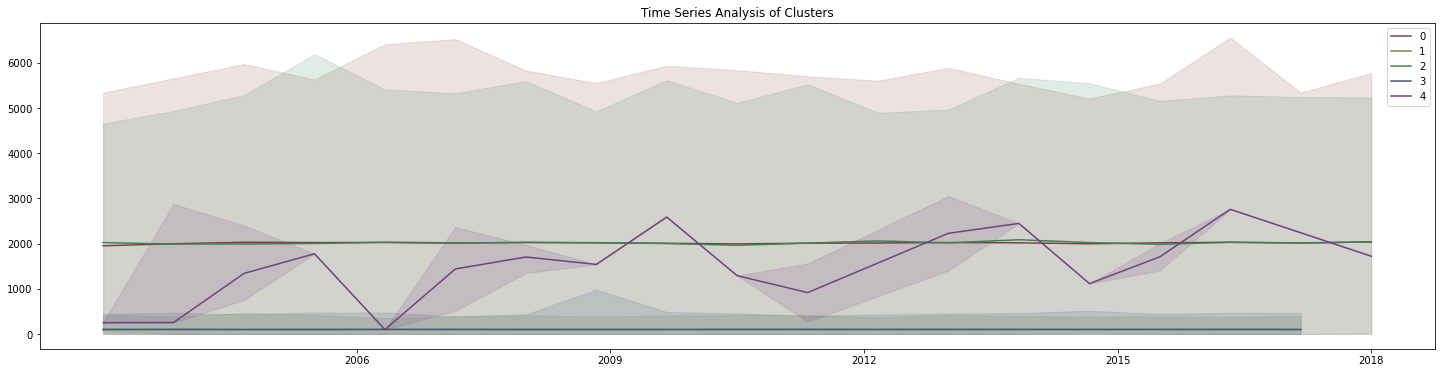

In [3]:
createTimeSeriesGraph(dates = np.array(premslabelled['effDate']), amounts = np.array(premslabelled['netPrem']), labels=np.array(premslabelled['cluster']), reduce='year', smooth = False, title='Time Series Analysis of Clusters')

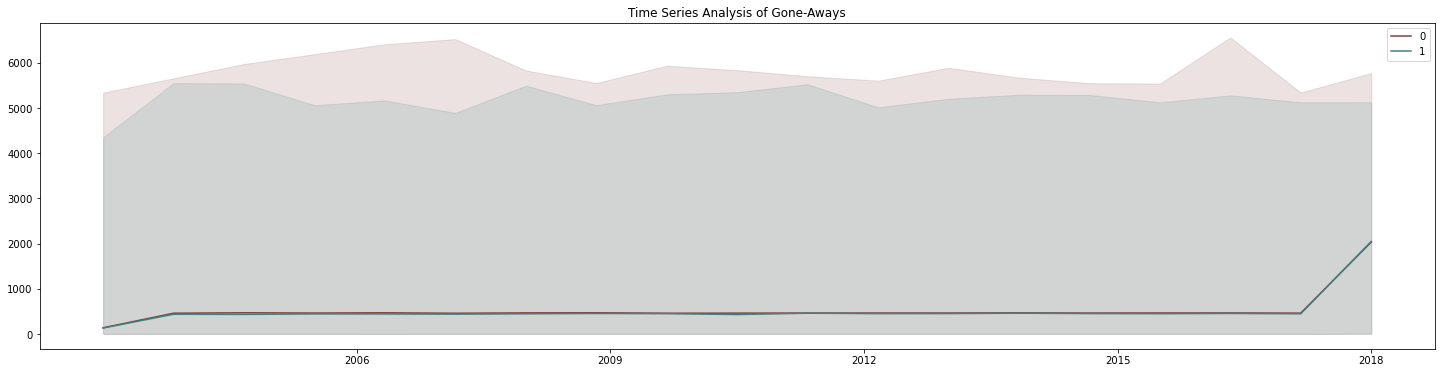

In [4]:
dataga = data[['perno','goneAway']]
premslabelled = pd.merge(prems,dataga, on = 'perno')

createTimeSeriesGraph(dates = np.array(premslabelled['effDate']), amounts = np.array(premslabelled['netPrem']), labels=np.array(premslabelled['goneAway']), reduce='year', smooth = False,title='Time Series Analysis of Gone-Aways')